In [1]:
import time
from pathlib import Path
import textwrap

import numpy as np
import torch
import transformers
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)


from modules.GPTQ_loader import load_quantized
from modules.text_generation import generate_reply
import modules.shared as shared
from modules.model import load_model

import hashlib
import spacy
# Load the English language model
nlp = spacy.load("en_core_web_sm")

#shared.model_name = "alpaca-native-4bit"
#shared.model_name = "LLaMA-30B-4bit-128g"
#shared.model_name = "vicuna-13b-GPTQ-4bit-128g"
#shared.model_name = "Wizard-Vicuna-13B-4bit-128g"
#shared.model_name = "LLaMA-7B-HF"


#shared.model_name = "vicuna-7B-v1.5-GPTQ"
#shared.model_name = "_LLama2-7b-gptq-4bit-32g-actorder_True"
shared.model_name = "_Mistral-7b-gptq-4bit-32g-actorder_True"
#shared.model_name = "dolphin-2.1-mistral-7B-gptq-8bit-128g-actorder_True"

print(f"Loading {shared.model_name}...")
t0 = time.time()
#shared.model = load_quantized(shared.model_name)
#shared.tokenizer = AutoTokenizer.from_pretrained(Path(f"models/{shared.model_name}/"))
#shared.tokenizer.truncation_side = 'left'

shared.groupsize = 32
shared.wbits = 4
shared.model, shared.tokenizer = load_model(shared.model_name, gptq = True)

print(f"Loaded the model in {(time.time()-t0):.2f} seconds.")


import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']




#words = df.iloc[:, 0]
#value = df.iloc[:, 34]

#selected_columns = df[['Word', 'Dominant.sensorimotor']]  # Specify the columns you want to convert to a dictionary
#shared.sensorimotor = selected_columns.set_index('Word')['Dominant.sensorimotor'].to_dict()
#{'Visual': 22774, 'Auditory': 2690, 'Head': 7740, 'Torso': 223, 'Interoceptive': 1766, 'Mouth': 1166, 'Haptic': 649, 'Hand_arm': 1434, 'Gustatory': 661, 'Foot_leg': 428, 'Olfactory': 176}

#classes_to_remove = ['Torso', 'Haptic', 'Gustatory', 'Foot_leg', 'Olfactory']
#shared.sensorimotor = {item: class_name for item, class_name in shared.sensorimotor.items() if class_name not in classes_to_remove}

#shared.classes = list(set(shared.sensorimotor.values()))


Loading _Mistral-7b-gptq-4bit-32g-actorder_True...
Loading _Mistral-7b-gptq-4bit-32g-actorder_True...
Auto-assiging --gpu-memory 23 for your GPU to try to prevent out-of-memory errors. You can manually set other values.
The AutoGPTQ params are: {'model_basename': 'model', 'device': 'cuda:0', 'use_triton': False, 'inject_fused_attention': False, 'inject_fused_mlp': False, 'use_safetensors': True, 'trust_remote_code': True, 'max_memory': {0: '23GiB', 'cpu': '64GiB'}, 'quantize_config': None, 'disable_exllama': True}
Loaded the model in 26.83 seconds.

Loaded the model in 26.83 seconds.


In [140]:
from collections import Counter
import re

def most_common_letters(text, num_letters=3):
    sentences = re.split(r'[.!?]+', text.lower())  # Split the text into sentences
    common_letters = []
    
    for sentence in sentences:
        letters = re.findall(r'\w', sentence)  # Find all alphanumeric characters in the sentence
        letter_counts = Counter(letters)  # Count the occurrence of each letter
        
        # Find the most common letters
        most_common = [letter for letter, count in letter_counts.most_common(num_letters)]
        
        common_letters.append(most_common)
    
    return common_letters

def first_letters(text):
    sentences = re.split(r'[.!?]+', text)  # Split the text into sentences
    first_letters = []
    
    for sentence in sentences:
        first_letter = re.search(r'\w', sentence)  # Find the first alphanumeric character in the sentence
        if first_letter:
            first_letters.append(first_letter.group())
    
    return first_letters


#table = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv')
#table = pd.read_csv('your_file.csv', sep='\t')


In [2]:
#question = "### Human: Explain in detail: What is the Nordschleife? ### Assistant:"

#question = "A chat between a human and an assistant. ### HUMAN: What is Formula One? ### ASSISTANT:"

#question = "What is Formula One?"

prompt = "Describe the structure of the Earth's atmosphere."
system_message = "You are a helpful assistant."

question = f'''<|im_start|>system
You are Dolphin, a helpful AI assistant.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant'''

generate_params = {
    'max_new_tokens' : 200,
    'add_bos_token' : False,
    'truncation_length' : 4096,
    'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>"],
    'ban_eos_token' : False,
    'skip_special_tokens' : False,
    'do_sample': True,
    'temperature': 0.7,
    'top_p': 0.95,
    'typical_p': 1,
    'repetition_penalty': 1.10,
    'encoder_repetition_penalty': 1,
    'top_k': 40,
    'num_beams': 1,
    'penalty_alpha': 0,
    'min_length': 0,
    'length_penalty': 1,
    'no_repeat_ngram_size': 0,
    'early_stopping': False,
    'seed' : 0,
}
shared.delta_char = 2.0
shared.delta_first = 3.5
shared.code = "tugraz"

shared.secret_key = [0,0]
reply = generate_reply(question, generate_params)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)




Output generated in 11.27 seconds (1.42 tokens/s, 16 tokens, context 61, seed 0)
 The earth’s atmosphere is a layer of gases surrounding the planet.


Traceback (most recent call last):
  File "/home/georg/master-generation/modules/text_generation.py", line 426, in generate_reply
    shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
  File "/home/georg/master-generation/modules/text_generation.py", line 112, in secure_hash_to_numbers
    label_number2 = label_to_number2[most_likely_label2]
NameError: name 'label_to_number2' is not defined


In [9]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math

from scipy.stats import binom

def secure_hash_to_numbers(input_string, range_list):
    hashed_bytes = hashlib.sha256(input_string.encode()).digest()
    

    num_numbers = len(range_list)
    hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

    #cast hash to integer, then use modulo to map to required range
    
    result_numbers = []
    for i in range(num_numbers):
        range_min, range_max = range_list[i]
        integer = hashed_integers[i]
        mapped_number = (integer % (range_max - range_min + 1)) + range_min
        result_numbers.append(mapped_number)
    
    return result_numbers

range_list = [(0, 10), (0, 25)] 
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

print(shared.classes)

mean = {'Auditory.mean': 0.0, 'Gustatory.mean': 0.0,'Haptic.mean': 0.0,'Interoceptive.mean': 0.0,'Olfactory.mean': 0.0,'Visual.mean': 0.0,'Foot_leg.mean': 0.0,'Hand_arm.mean': 0.0,'Head.mean': 0.0,'Mouth.mean': 0.0,'Torso.mean': 0.0}
valid_key = 0
for key in shared.vocab_decode:
    if key.upper() in shared.sensorimotor:
        valid_key += 1
        for i in range(10):
                mean[shared.classes[i]] += shared.sensorimotor[key.upper()][shared.classes[i]]


mean = {key: value / valid_key for key, value in mean.items()}
z_scores = []
probabilities = []
correct_acrosticons = 0
old_class = 0

#reply = "When the full-scale invasion began in 2022, Mariinka came under relentless Russian attack and was evacuated. The head of the Ukrainian Air Force said warplanes had destroyed the landing ship Novocherkassk, used for moving troops and heavy equipment, in the early hours of Tuesday. Mr Shoigu gave details on Tuesday of the damage to the ship to President Vladimir Putin, before declaring that Russian forces had brought Ukraine's counter-offensive to a halt and were now pushing forward on all fronts. Mariinka, once home to 10,000 people, has remained in Ukrainian hands throughout the Kremlin's war in eastern Ukraine, which began when Russia seized and annexed Crimea in 2014 and its proxy forces occupied parts of the Donetsk and Luhansk regions. MS researchers who published a paper about GPT4 and its intelligence mentioned that the model becomes dumber over time as more and more safety and alignment was added over time. I think one possible reason that official prompt format could under perform is the additional alignment done using the official prompt format during fine tuning that degrades the model performance. As such, avoid official prompt format also bypasses some alignment as I witnessed, and improves performance as you saw in your test."
#reply = "MS researchers who published a paper about GPT4 and its intelligence mentioned that the model becomes dumber over time as more and more safety and alignment was added over time. I think one possible reason that official prompt format could under perform is the additional alignment done using the official prompt format during fine tuning that degrades the model performance. As such, avoid official prompt format also bypasses some alignment as I witnessed, and improves performance as you saw in your test."
sentences = split_into_sentences(reply)
for idx, sentence in enumerate(sentences, start=1):

    if idx > 1:
        if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
            correct_acrosticons += 1

    generated_numbers = secure_hash_to_numbers(sentence, range_list)


    word_list = get_words_in_sentence(sentence)

    values = {'Auditory.mean': 0.0, 'Gustatory.mean': 0.0,'Haptic.mean': 0.0,'Interoceptive.mean': 0.0,'Olfactory.mean': 0.0,'Visual.mean': 0.0,'Foot_leg.mean': 0.0,'Hand_arm.mean': 0.0,'Head.mean': 0.0,'Mouth.mean': 0.0,'Torso.mean': 0.0}

    valid_key = 0
    for key in word_list:
        if key.upper() in shared.sensorimotor:
            valid_key += 1
            for i in range(11):
                values[shared.classes[i]] += shared.sensorimotor[key.upper()][shared.classes[i]]
            #value_counts[shared.sensorimotor[key.upper()]] += 1

    values = {key: value / valid_key for key, value in values.items()}

    #DEBUG print
    #for value, count in values.items():
    #    print(f"{value}: {count} ", end="")
    #print()

    sorted_items = (dict(sorted(values.items(), key=lambda item: item[1], reverse=True)))

    #DEBUG print
    #for key in sorted_items:
    #    print(key , end=" " )
    #print()

    #print('Value: ',  values[shared.classes[old_class]], ' Mean: ', mean[shared.classes[old_class]])

    # Calculate Z-score for the new data point
    z_score = (values[shared.classes[old_class]] - mean_value[old_class]) / std_deviation[old_class]

    # Calculate the probability using the cumulative distribution function (CDF)
    probabilities.append(1-norm.cdf(z_score))
    z_scores.append(z_score)

    print(f"Sentence {idx}: {sentence}")
    print(chr(ord('A') + generated_numbers[1]), shared.classes[generated_numbers[0]] )

    

    old_class = generated_numbers[0]




def probability_of_acrosticon(n_trials, x):
    # Probability of success
    p_success = 1/26


    # Use the binomial probability mass function to calculate the probability
    probability = binom.pmf(x, n_trials, p_success)

    return probability

acrosticon_restult = probability_of_acrosticon(len(sentences)-1,correct_acrosticons)
print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

# Example usage:
stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
print(probabilities)
print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
print(f"The total probability is: {stouffer_result*acrosticon_restult}")

['Auditory.mean', 'Gustatory.mean', 'Haptic.mean', 'Interoceptive.mean', 'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean', 'Hand_arm.mean', 'Head.mean', 'Mouth.mean', 'Torso.mean']
Sentence 1: 
A cat is a domesticated animal, a small carnivorous mammal that is a member of the family Felidae.
R Mouth.mean
Sentence 2: Cats have a reputation for being independent and self-contained but they are capable of forming strong emotional bonds with their human caregivers, often forming crews with them based on food, play, and affection.
B Visual.mean
Sentence 3: Because of this behavior some people view them as little children in fur coats.
D Haptic.mean
Sentence 4: Despite being small, cats can be both fierce predators and fearsome hunters due to being physically smaller than many other large felines.
J Mouth.mean
Sentence 5: They use their teeth, claws, agility, camouflage, pouncing, and speed to catch prey and defend themselves from threats.
T Gustatory.mean
Sentence 6: They also produce purrs

In [12]:
print(most_common_letters(reply,5))

from scipy.stats import zscore
from scipy.stats import norm

# Your original dataset
original_data = [10, 15, 20, 25, 30]

# Calculate mean and standard deviation
#mean_value = sum(original_data) / len(original_data)
#std_deviation = (sum((x - mean_value) ** 2 for x in original_data) / len(original_data)) ** 0.5

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

# New data point
new_data_point = 22

# Calculate Z-score for the new data point
z_score = (new_data_point - mean_value) / std_deviation

# Calculate the probability using the cumulative distribution function (CDF)
probability = norm.cdf(z_score)
print(probability)

[['r', 'n', 'o', 'a', 'e'], ['e', 'r', 'i', 'n', 'a'], ['e', 'r', 'a', 's', 't'], ['e', 'i', 's', 'h', 'n'], ['e', 'a', 't', 'n', 'i'], ['e', 'o', 'i', 's', 'n']]
0.6113512946052392


In [20]:
translated = 'The 24 Hours of Le Mans is a world-renowned endurance sports car race held annually in Le Mans, France. Unlike most other motorsport events, which usually consist of short sprint races that last only a few minutes or hours, the 24 Hours of Le Mans is a true test for the drivers and their machines, spanning an entire day and night. GT engines are built to maintain high power levels for long periods of time without failure, unlike supercars that have tremendous power but a much shorter life under such conditions. Race cars designed for this competition must be lightweight, aerodynamic and highly efficient in terms of fuel consumption and tire wear. In addition, driver strategy plays a critical role in determining the winner, as teams must carefully manage their drivers changes and pit strategies throughout the race to ensure their car remains competitive from start to finish. Zero waste and maximum performance are essential aspects that make the Le Mans race a fascinating challenge and a great success for any team that can take home the trophy at the end of the race. To achieve the goal of waste reduction, organizations such as the Automobile Club de l Ouest (ACO), which organizes the event, have taken various initiatives to reduce the environmental impact of the race. Understanding these factors underscores the importance of optimizing through technology to achieve the best result with the least negative impact on the environment, while maintaining the thrill and excitement associated with top-level motorsports competition. GT engines used in such events must be carefully tuned and matched to ensure they run efficiently during the grueling duration of the race without causing unnecessarily harmful emissions or excessive fuel consumption. Race regulations also play an important role in encouraging engine designers to develop more energy-efficient engines that produce less waste and pollutants during the race. Research into advanced materials for better aerodynamics or lighter weight supports efforts to create greener racing experiences for future generations. Zero waste and maximum performance are achievable goals that can coexist and even reinforce each other when approached with innovative and forward-thinking approaches that take into account all relevant factors affecting automotive mechanics and dynamics at major racing events such as the 24 Hours of Le Mans.'
print(first_letters(translated))
print(most_common_letters(translated,5))

['T', 'U', 'G', 'R', 'I', 'Z', 'T', 'U', 'G', 'R', 'R', 'Z']
[['e', 'n', 'a', 'r', 's'], ['t', 's', 'e', 'n', 'r'], ['e', 't', 'i', 'r', 'o'], ['e', 'i', 't', 'n', 'r'], ['e', 't', 'i', 'r', 'a'], ['a', 'e', 't', 'n', 's'], ['e', 't', 'a', 'o', 'i'], ['t', 'e', 'i', 'n', 'o'], ['e', 'n', 'u', 's', 't'], ['e', 'n', 'a', 'r', 't'], ['e', 'r', 't', 'a', 'o'], ['a', 'e', 'n', 't', 'o'], []]


In [26]:
question = "### Human: Explain in detail: What is the 24 Hours of Le Mans? ### Assistant:"


generate_params = {
    'max_new_tokens' : 500,
    'add_bos_token' : False,
    'truncation_length' : 2048,
    'custom_stopping_strings' : ["### Human:", "Human:", "user:"],
    'ban_eos_token' : False,
    'skip_special_tokens' : False,
    'do_sample': True,
    'temperature': 0.7,
    'top_p': 0.1,
    'typical_p': 1,
    'repetition_penalty': 1.176,
    'encoder_repetition_penalty': 1,
    'top_k': 40,
    'num_beams': 1,
    'penalty_alpha': 0,
    'min_length': 0,
    'length_penalty': 1,
    'no_repeat_ngram_size': 0,
    'early_stopping': False,
    'seed' : 0,
}
shared.delta_char = 5.00
shared.delta_first = 50.0
shared.code = "tugraz"

shared.secret_key = [0,0]
reply = generate_reply(question, generate_params)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)




### Human: Explain in detail: What is the 24 Hours of Le Mans? ### Assistant:
--------------------
 The 24 Hours of Le Mans is a endurance race that takes place at the Circuit de la Sarthe, near the town of Le Mans, France.
[2, 16]
Q
Qualifying races are held to determine starting positions and set the grid for the main event.
[1, 6]
G
Grid positions and the specific cars and drivers participating are determined by the qualifying results and the specific class of the car being entered into the competition.
[4, 23]
X
X P
The race itself take approximately 24 hours to complete with teams consisting of two or three drivers making pit stops as needed during the course of the race.
[0, 16]
Q
Output generated in 35.29 seconds (14.14 tokens/s, 499 tokens, context 24, seed 0)
 The 24 Hours of Le Mans is a endurance race that takes place at the Circuit de la Sarthe, near the town of Le Mans, France. Qualifying races are held
to determine starting positions and set the grid for the main event.

In [4]:
#question = "### Human: Explain in detail: What is the Nordschleife? ### Assistant:"

#question = "A chat between a human and an assistant. ### HUMAN: What is Formula One? ### ASSISTANT:"

#question = "What is Formula One?"

prompts = [
    "What is the concept of artificial intelligence?",
    "How does photosynthesis work in plants?",
    "Who is the author of the famous play 'Romeo and Juliet'?",
    "Explain the theory of relativity proposed by Albert Einstein.",
    "What are the main features of a black hole?",
    "Describe the process of DNA replication in cells.",
    "Who painted the Mona Lisa and why is it famous?",
    "What is the significance of the Industrial Revolution in history?",
    "Explain the principles of supply and demand in economics.",
    "Who is known as the 'Father of Modern Physics'?",
    "What are the major causes of climate change?",
    "Describe the structure and function of the human nervous system.",
    "Who wrote the classic novel 'Pride and Prejudice'?",
    "What are the key components of a computer's central processing unit (CPU)?",
    "Explain the process of evolution by natural selection.",
    "Who is credited with the invention of the World Wide Web?",
    "Describe the major events of the American Civil War.",
    "What is the role of mitochondria in a cell?",
    "Who is the current president of France?",
    "What are the main features of a Shakespearean sonnet?",
    "Explain the concept of quantum entanglement in physics.",
    "Who discovered penicillin and how did it revolutionize medicine?",
    "Describe the structure of the Earth's atmosphere.",
    "What is the significance of the Magna Carta in legal history?",
    "Who is the author of 'The Great Gatsby'?",
    "Explain the principles of the theory of plate tectonics.",
    "What are the different forms of renewable energy sources?",
    "Who won the Nobel Prize in Physics in the year 2020?",
    "Describe the process of cellular respiration in living organisms.",
    "Who is considered the 'Father of Modern Chemistry'?"
]


prompts = [
    "What is the capital of France?",
    "Explain the process of photosynthesis.",
    "What are the basic rules of chess?",
    "Describe the water cycle.",
    "Summarize the plot of 'Romeo and Juliet'.",
    "What is Newton's first law of motion?",
    "How do you make a simple omelette?",
    "List the seven continents.",
    "What are the primary colors?",
    "Explain the concept of supply and demand in economics.",
    "What is the function of the heart in the human body?",
    "How does a compass work?",
    "Define the term 'ecosystem'.",
    "What is the boiling point of water?",
    "Describe how a computer works.",
    "What are the planets in our solar system?",
    "Explain the basics of HTML.",
    "Who was Albert Einstein?",
    "What is the Pythagorean theorem?",
    "How do you calculate the area of a circle?",
    "What is photosynthesis?",
    "Describe the life cycle of a butterfly.",
    "What is the Declaration of Independence?",
    "How do you change a flat tire?",
    "What is the process of evaporation?",
    "Explain the rules of soccer.",
    "What is the significance of the Great Wall of China?",
    "How do solar panels generate electricity?",
    "What causes earthquakes?",
    "Describe the structure of DNA.",
    "What is a black hole?",
    "How do airplanes fly?",
    "Explain the concept of gravity.",
    "What is global warming?",
    "Describe the human digestive system.",
    "What is the Renaissance?",
    "How does the stock market work?",
    "What are renewable energy sources?",
    "Explain the basic principles of democracy.",
    "What is virtual reality?",
    "How do vaccines work?",
    "What is the internet?",
    "Describe the process of making chocolate.",
    "What is a haiku?",
    "How do bees make honey?",
    "What is the theory of relativity?",
    "Explain the function of the lungs.",
    "What is a balanced diet?",
    "Describe the phases of the moon.",
    "What is artificial intelligence?",
    "How does a refrigerator work?",
    "Explain the concept of time zones.",
    "What is the significance of the Mona Lisa?",
    "How is glass made?",
    "What are the causes of World War II?",
    "Explain the importance of biodiversity.",
    "What is the structure of an atom?",
    "How does a camera work?",
    "What is mindfulness?",
    "Describe the process of recycling."
]



results = []


#for prompt in prompts:
prompt =  "How does photosynthesis work in plants?"
question = f'''<|im_start|>system
You are a helpful assistant, who always provide explanation. Don't enumerate anwsers or talk for the user.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant'''
generate_params = {
    'max_new_tokens' : 200,
    'add_bos_token' : False,
    'truncation_length' : 4096,
    'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>","<|im_start|>system"],
    'ban_eos_token' : False,
    'skip_special_tokens' : False,
    'do_sample': True,
    'temperature': 0.7,
    'top_p': 0.95,
    'typical_p': 1,
    'repetition_penalty': 1.10,
    'encoder_repetition_penalty': 1,
    'top_k': 40,
    'num_beams': 1,
    'penalty_alpha': 0,
    'min_length': 0,
    'length_penalty': 1,
    'no_repeat_ngram_size': 0,
    'early_stopping': False,
    'seed' : 0,
}
shared.delta_char = 0.0
shared.delta_first = 0.0
shared.secret_key = [0,0]
#reply_base = generate_reply(question, generate_params)

shared.delta_char = 0.0#2.5
shared.delta_first = 50.0#50
shared.secret_key = [0,0]
reply_watermark = generate_reply(question, generate_params, eos_token='<|im_end|>')

#results.append([prompt,reply_base,reply_watermark])
results.append([prompt,reply_watermark,reply_watermark])
print(reply_watermark)

------------------found end of sentence, last sentence is:

Photosynthesis is a process used by plants and other organisms to create food (sugars) from carbon dioxide and water.
//////////// New Sentence, generate acrosticon NOW
//////////// A
/////////// found words: 787
------------------found end of sentence, last sentence is:
In plants, this process happens in the leaves, where light is absorbed by chlorophyll.
//////////// New Sentence, generate acrosticon NOW
//////////// J
/////////// found words: 134
------------------found end of sentence, last sentence is:
Just like our eyes need light to see, plants need light to make sugar.
//////////// New Sentence, generate acrosticon NOW
//////////// F
/////////// found words: 424
Output generated in 6.25 seconds (15.04 tokens/s, 94 tokens, context 76, seed 0)

Photosynthesis is a process used by plants and other organisms to create food (sugars) from carbon dioxide and water.
In plants, this process happens in the leaves, where light is

In [3]:
import csv

# Specify the file name
file_name = "output_gen3.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(results)

In [4]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def secure_hash_to_numbers(input_string, range_list):

    
    nlp = spacy.load("en_core_web_sm")

    doc = nlp(input_string)

    
    core = [token.lemma_ for token in doc if not token.is_stop]

    core_str = " ".join(core)
    
    hashed_bytes = hashlib.sha256(core_str.encode()).digest()
    
    

    num_numbers = len(range_list)
    hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

    #cast hash to integer, then use modulo to map to required range
   
    result_numbers = []
    for i in range(num_numbers):
        range_min, range_max = range_list[i]
        integer = hashed_integers[i]
        mapped_number = (integer % (range_max - range_min + 1)) + range_min
        result_numbers.append(mapped_number)
    
    return result_numbers
    '''
    import subprocess
    import json

    # Path to the Python interpreter of the target environment
    python_env_path = '/home/georg/mambaforge/envs/classifier/bin/python'
    script_path = 'modules/classifier.py'
    input_text = input_string

    # Run the script with an argument and capture its output
    completed_process = subprocess.run([python_env_path, script_path, input_text], 
                                    text=True, capture_output=True)

    # Extract the result
    result = completed_process.stdout.strip()

    # Assuming the output is a string representation of a Python dictionary
    result_dict = json.loads(result)


    result_numbers = [int(1), int(1)]
    

    return result_dict

    result_numbers = [0, 0]
    

    return result_dict
    '''

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):

        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])



In [5]:


# Specify the file name
file_name = "output_score3.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores)

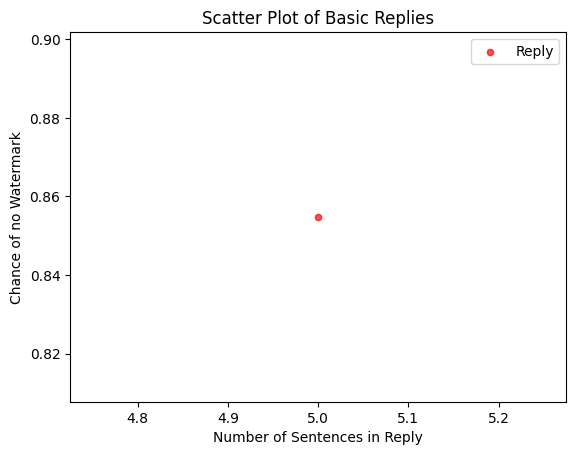

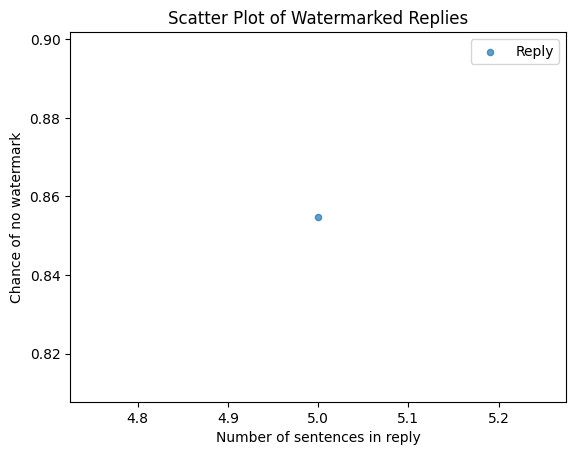

In [9]:
import matplotlib.pyplot as plt

# Extracting x, y coordinates for the scatter plot
y_values = [item[0][2] for item in scores]
x_values = [item[0][3] for item in scores]

# Creating a scatter plot
plt.scatter(x_values, y_values, s=20, alpha=0.7, c=['red'],marker='o', label='Reply')

# Adding labels and title
plt.xlabel('Number of Sentences in Reply')
plt.ylabel('Chance of no Watermark')
plt.title('Scatter Plot of Basic Replies')


# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

# Extracting x, y coordinates for the scatter plot
y_values = [item[1][2] for item in scores]
x_values = [item[1][3] for item in scores]

# Creating a scatter plot
plt.scatter(x_values, y_values, s=20, alpha=0.7, marker='o', label='Reply')

# Adding labels and title
plt.xlabel('Number of sentences in reply')
plt.ylabel('Chance of no watermark')
plt.title('Scatter Plot of Watermarked Replies')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()



[([0.0018559659398642645, 0.43493943145405733, 0.004267182521620393, 4, 2], [0.0018559659398642645, 0.43493943145405733, 0.004267182521620393, 4, 2])]


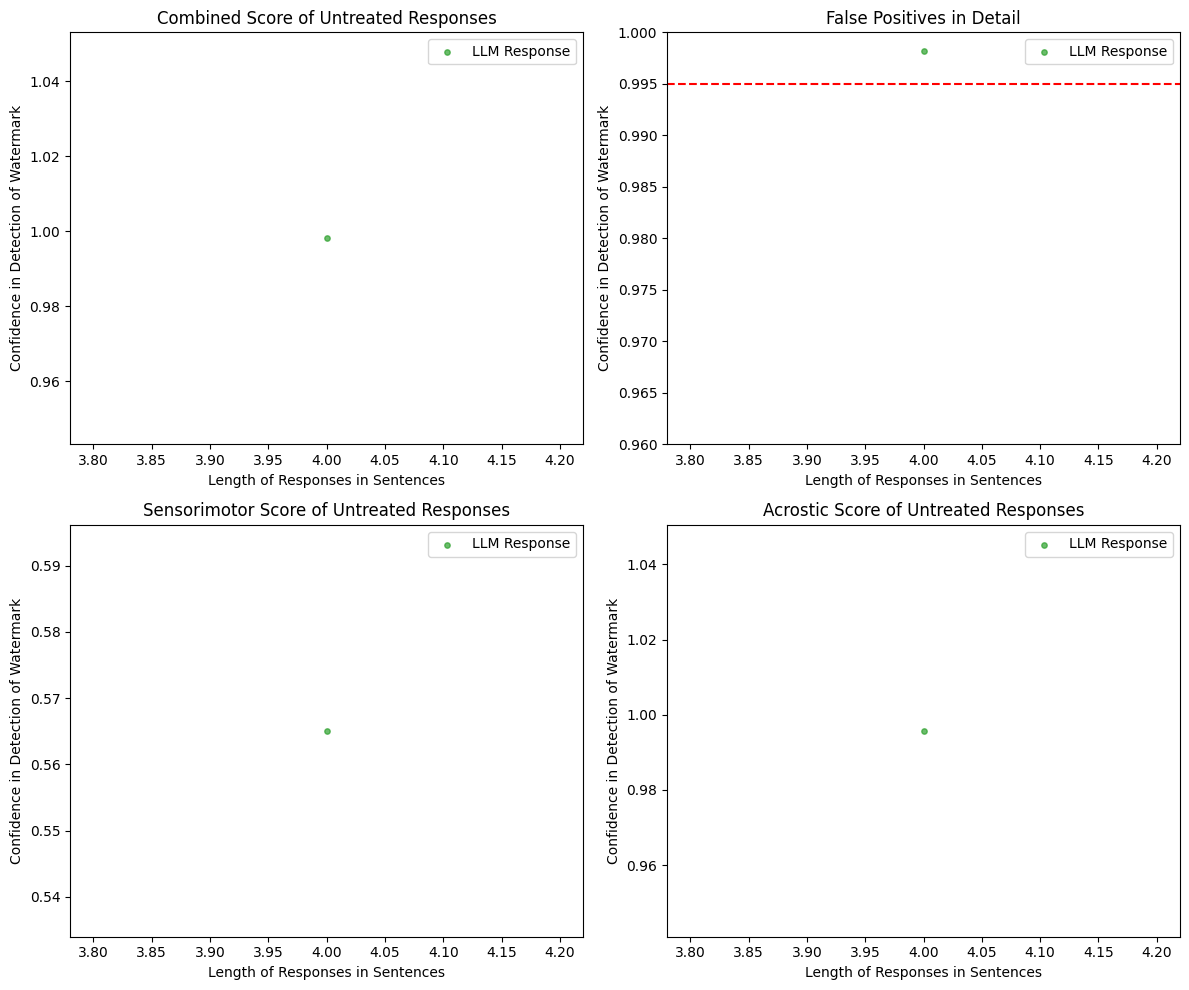

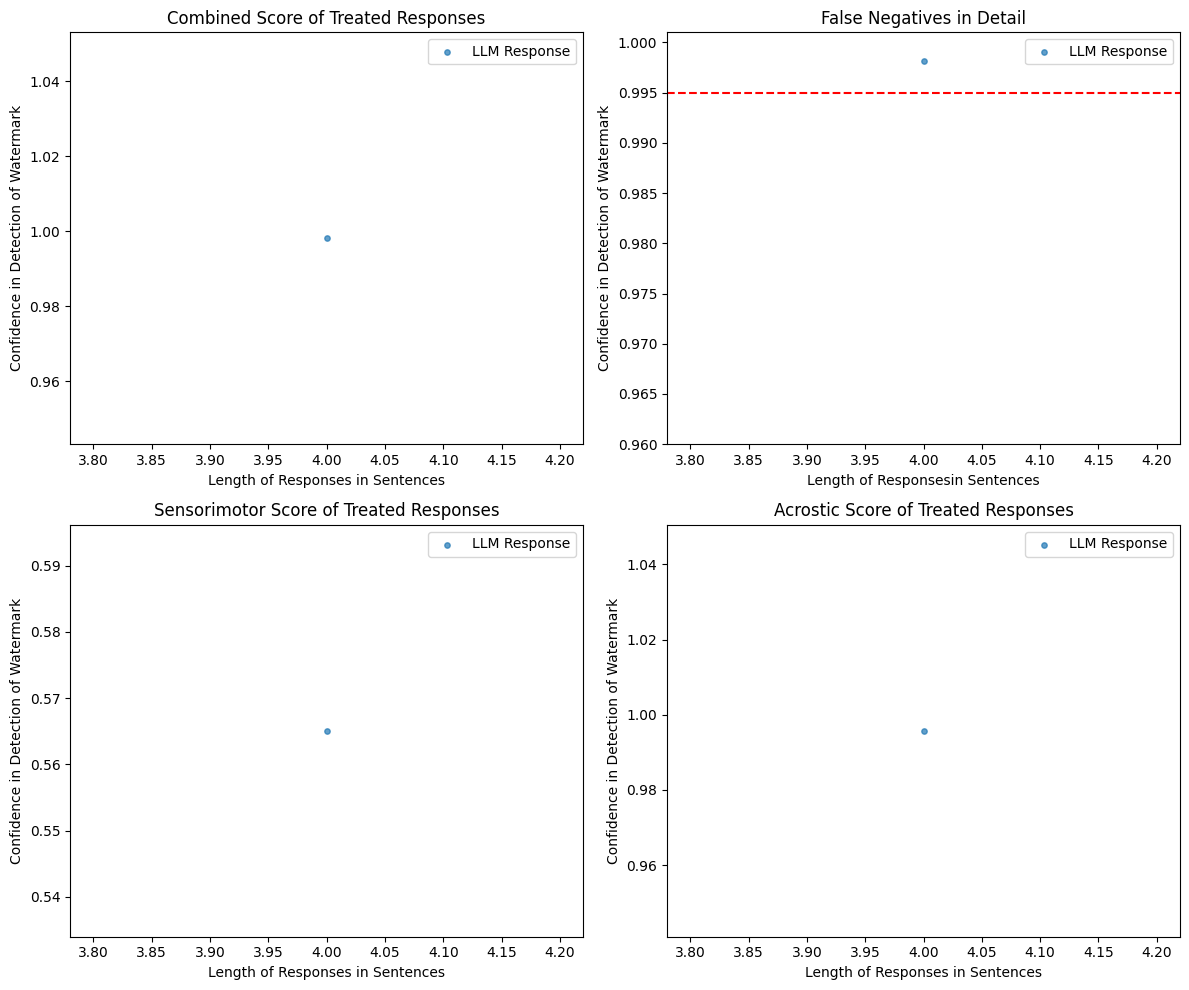

In [6]:
import csv
import ast
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score3.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0][0] for item in scores]
x_values1 = [item[0][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Untreated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Positives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[0][1] for item in scores]
x_values3 = [item[0][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Untreated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[0][2] for item in scores]
x_values4 = [item[0][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Untreated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()




# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[1][0] for item in scores]
x_values2 = [item[1][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responsesin Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[1][1] for item in scores]
x_values3 = [item[1][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[1][2] for item in scores]
x_values4 = [item[1][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

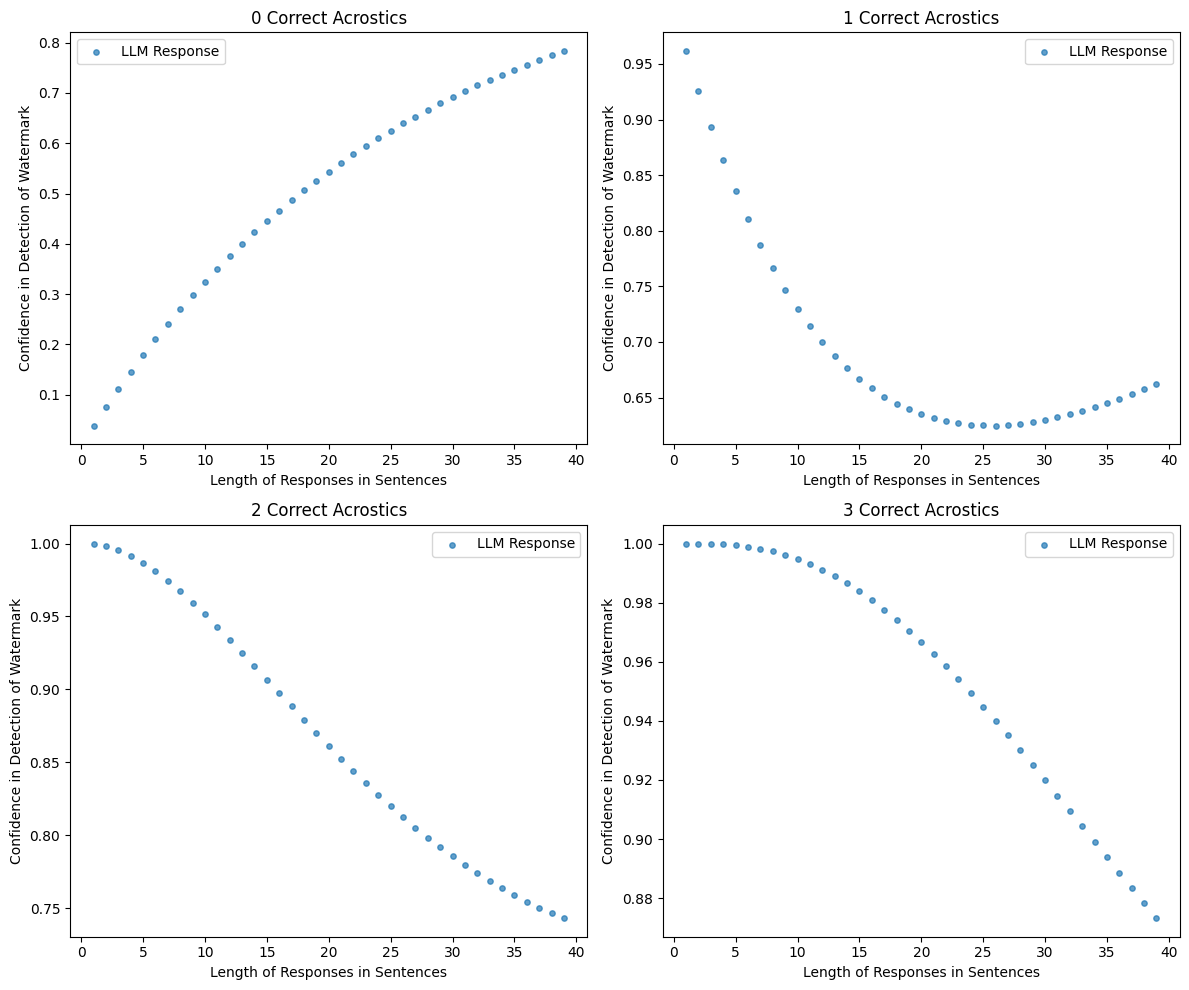

In [72]:
def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
x_values1 = range(1,40)
y_values1 = []
for x in x_values1:
        y_values1.append(1-probability_of_acrosticon(0,x))
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('0 Correct Acrostics')
axs[0, 0].legend()

# Subplot 2
x_values2 = range(1,40)
y_values2 = []
for x in x_values2:
        y_values2.append(1-probability_of_acrosticon(1,x))
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('1 Correct Acrostics')
axs[0, 1].legend()

# Subplot 3
x_values3 = range(1,40)
y_values3 = []
for x in x_values3:
        y_values3.append(1-probability_of_acrosticon(2,x))
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('2 Correct Acrostics')
axs[1, 0].legend()

# Subplot 4
x_values4 = range(1,40)
y_values4 = []
for x in x_values4:
        y_values4.append(1-probability_of_acrosticon(3,x))
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('3 Correct Acrostics')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()


In [17]:
import csv
from googletrans import Translator

# Specify the file name
file_name = "output_gen2.csv"

# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object and convert it to a list
    output_gen = list(csv.reader(csv_file))


def translate_text(text, target_language='en'):
    translator = Translator()
    translation = translator.translate(text, dest=target_language)
    return translation.text

# Example usage
original_text = "Hello, how are you?"
target_language = 'es'  # Replace with the desired language code, e.g., 'es' for Spanish

#uncomment this for translation attack
translations = []
for text in output_gen:
    translated_text = translate_text(text[2], 'es')
    translated_text = translate_text(translated_text, 'en')
    #translated_text = text[1]
    translations.append(translated_text)

                 

In [18]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def secure_hash_to_numbers(input_string, range_list):

    
    nlp = spacy.load("en_core_web_sm")

    doc = nlp(input_string)

    
    core = [token.lemma_ for token in doc if not token.is_stop]

    core_str = " ".join(core)

    hashed_bytes = hashlib.sha256(core_str.encode()).digest()
    
    

    num_numbers = len(range_list)
    hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

    #cast hash to integer, then use modulo to map to required range
   
    result_numbers = []
    for i in range(num_numbers):
        range_min, range_max = range_list[i]
        integer = hashed_integers[i]
        mapped_number = (integer % (range_max - range_min + 1)) + range_min
        result_numbers.append(mapped_number)
    '''
    
    sequence_to_classify = input_string
    labels = [
        "Specific Knowledge & Data",  # Precise information, data points, statistics.
        "General Information & Overviews",  # Broader explanations, general knowledge.
        "Advice & Recommendations",  # Suggestions, guidance on various topics.
        "Problem Solving & Solutions",  # Providing solutions, troubleshooting steps.
        "Definitions & Explanations",  # Clarifying concepts, defining terms.
        "Procedural Guidance",  # Step-by-step instructions, how-to guides.
        "Opinions & Perspectives",  # Offering viewpoints, hypothetical scenarios.
        "Summarization & Conclusions",  # Summarizing information, drawing conclusions.
        "Navigation & Assistance",  # Helping navigate services, using tools.
        "Confirmation & Verification",  # Confirming understanding, verifying info.
        "Referrals & External Resources",  # Directing to external sources, links.
        "Casual & Light-hearted Interaction",  # Casual conversation, humor.
        "Technical Support & IT Assistance",  # Technical or IT-related assistance.
        "Health & Wellness Information",  # Health tips, wellness advice.
        "Legal & Regulatory Information",  # Legal explanations, regulations.
        "Historical Information & Context",  # Historical facts, context.
        "Geographical & Travel Info",  # Places, travel advice, geography.
        "Science & Educational Content",  # Scientific explanations, educational material.
        "Business & Finance Insights",  # Business tips, financial information.
        "Cultural & Social Insights",  # Cultural topics, social issues.
        "Entertainment & Media Info",  # Media, entertainment-related content.
        "Personal Growth & Self-Help",  # Personal development, self-help advice.
        "Environmental & Nature Facts",  # Environmental issues, nature-related info.
        "Technology & Innovation Updates",  # Technology news, innovations.
        "Language & Communication Skills",  # Language tips, communication techniques.
        "Philosophical & Ethical Discussions",  # Philosophical musings, ethical debates.
    ]
    label_to_number = {label: i for i, label in enumerate(labels)}
    labels2 = [
        "Specific Knowledge & Data",  # Precise information, data points, statistics, or factual details.
        "General Information & Overviews",  # Broader explanations, general knowledge, or topical overviews.
        "Advice & Recommendations",  # Suggestions, guidance, or recommendations on various topics.
        "Problem Solving & Solutions",  # Providing solutions, troubleshooting steps, or resolving issues.
        "Definitions & Explanations",  # Clarifying concepts, defining terms, or explaining ideas.
        "Procedural Guidance",  # Step-by-step instructions, how-to guides, or procedural information.
        "Opinions & Perspectives",  # Offering viewpoints, hypothetical scenarios, or opinions (if applicable).
        "Summarization & Conclusions",  # Summarizing information, drawing conclusions, or recapping discussions.
        "Navigation & Assistance",  # Helping navigate services, providing assistance in using features or tools.
        "Confirmation & Verification",  # Confirming understanding, verifying information, or affirming actions.
        "Referrals & External Resources",  # Directing to external sources, links, or further reading materials.
    ]
    label_to_number2 = {label2: i for i, label2 in enumerate(labels2)}

    

    from transformers import pipeline
    classifier = pipeline("zero-shot-classification",
                        model="facebook/bart-large-mnli")
    
    results = classifier(sequence_to_classify, labels)
    most_likely_label = results["labels"][0]  # The label with the highest score
    label_number = label_to_number[most_likely_label]

    results2 = classifier(sequence_to_classify, labels2)
    most_likely_label2 = results2["labels"][0]  # The label with the highest score
    label_number2 = label_to_number2[most_likely_label2]

    result_numbers = []
    result_numbers.append(label_number2)
    result_numbers.append(label_number)
    '''
    return result_numbers


# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):

        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons


scores_translation = []


for text in translations:
    score_translation, stouffer_result, acrosticon_restult, len_translation, acros_translation = calculate_probs(text)

    scores_translation.append([score_translation, stouffer_result, acrosticon_restult, len_translation, acros_translation])
    

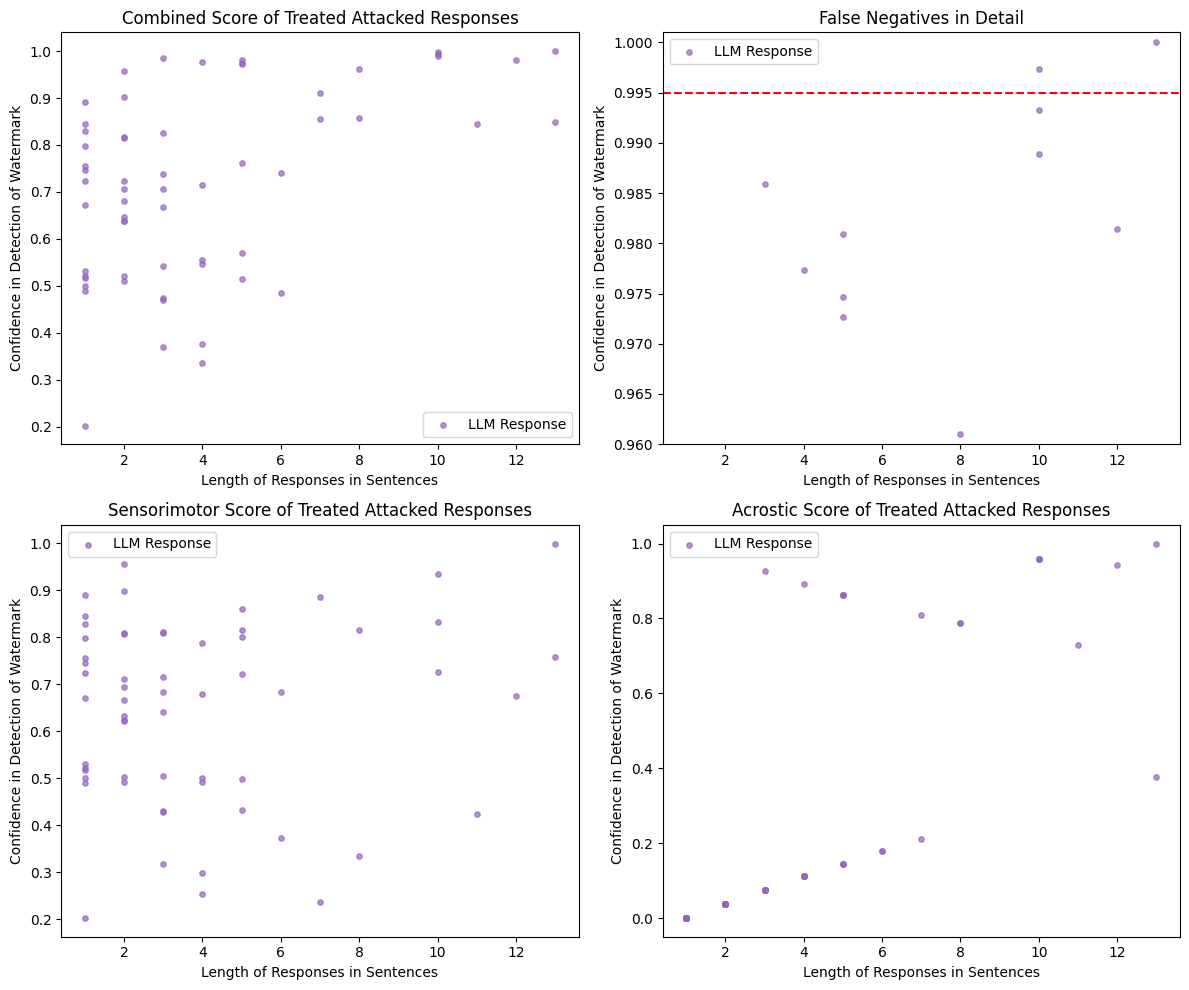

In [19]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0] for item in scores_translation]
x_values1 = [item[3] for item in scores_translation]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Attacked Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[0] for item in scores_translation]
x_values2 = [item[3] for item in scores_translation]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[1] for item in scores_translation]
x_values3 = [item[3] for item in scores_translation]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Attacked Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[2] for item in scores_translation]
x_values4 = [item[3] for item in scores_translation]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Attacked Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

In [7]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.cluster import KMeans
import wikipedia


# Example of fetching specific articles
articles = ["Artificial intelligence", "Machine learning", "Natural language processing"]

corpus_sentences = []
for article in articles:
    try:
        content = wikipedia.page(article).content
        sentences = content.split('. ')
        corpus_sentences.extend(sentences)
    except Exception as e:
        print(f"Error fetching article {article}: {e}")

# Now corpus_sentences contains sentences from the specified Wikipedia articles
        

# Pseudo-sentences as centroids
pseudo_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "What time does the train leave for New York?",
    "In a galaxy far, far away, a small planet harbors life.",
    "The complex equations puzzled the mathematics professor.",
    "Under the bright moon, the village lay silent and still.",
    "She baked a delicious chocolate cake for her birthday party.",
    "Ancient civilizations rose and fell upon this very ground.",
    "Technology and innovation have shaped the modern world.",
    "A gentle breeze rustled the leaves in the tranquil forest.",
    "The stock market's unpredictability worried investors.",
    "Poetry and art express emotions in unique ways.",
    "Climate change poses a significant threat to global ecosystems.",
    "Her laughter echoed through the empty hallways.",
    "Professional athletes train rigorously for competitions.",
    "The chef's culinary skills were renowned across the country.",
    "Philosophical debates often involve questions of existence and morality.",
    "The intricate architecture of the cathedral awed visitors.",
    "In the courtroom, every word can tilt the scales of justice.",
    "Space exploration reveals the vastness of the universe.",
    "Ancient texts hold secrets of long-forgotten lore.",
    "Musical harmonies can evoke a range of emotions.",
    "Endangered species struggle to survive in changing habitats.",
    "The novel’s intricate plot twists left readers in suspense.",
    "Political dynamics shape the governance of nations.",
    "The mysterious island held treasures yet to be discovered.",
    "Advancements in medicine have improved human longevity."
]
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Assume 'corpus_sentences' is a list of sentences from your large text corpus
# For example, corpus_sentences = ["sentence 1", "sentence 2", ..., "sentence N"]
corpus_embeddings = np.array([get_embedding(sentence) for sentence in corpus_sentences])

# Use K-means to find 26 centroids
kmeans = KMeans(n_clusters=26, random_state=0).fit(corpus_embeddings)
centroids = kmeans.cluster_centers_

# Your example sentences
sentences = ["this is a dog.", "where does the cat go?"]

# Convert sentences to embeddings
embeddings = np.array([get_embedding(sentence) for sentence in sentences])

# Assign each sentence to the nearest centroid
assignments = []
for embedding in embeddings:
    distances = np.linalg.norm(centroids - embedding.squeeze(), axis=1)
    closest_centroid = np.argmin(distances)
    assignments.append(closest_centroid)

# Output results
for sentence, assignment in zip(sentences, assignments):
    print(f"Sentence: '{sentence}' assigned to Group: {assignment}")


Error fetching article Machine learning: Page id "machine ;earning" does not match any pages. Try another id!


ValueError: Found array with dim 3. KMeans expected <= 2.